In [4]:
import os
from os import walk
import gc
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import mlflow
import mlflow.sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing

import optuna

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [5]:
#mixed_precision.set_global_policy('mixed_float16')
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Loading and processing data

In [6]:
df = pd.read_csv('project1_output.csv')

In [7]:
# fix due to some columns having bad characters
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#### Converting cols to their appropriate types again because we lost it on the csv export

In [8]:
df["product_category_name"] = df["product_category_name"].astype('category')
df["order_status"] = df["order_status"].astype('category')
df["review_score"] = df["review_score"].astype('category')
df["payment_type"] = df["payment_type"].astype('category')
df["customer_zip_code_prefix"] = df["customer_zip_code_prefix"].astype('category')
df["customer_city"] = df["customer_city"].astype('category')
df["customer_state"] = df["customer_state"].astype('category')
df["seller_zip_code_prefix"] = df["seller_zip_code_prefix"].astype('category')
df["seller_city"] = df["seller_city"].astype('category')
df["seller_state"] = df["seller_state"].astype('category')

df["product_name_lenght"] = df["product_name_lenght"].astype('int64')
df["product_description_lenght"] = df["product_description_lenght"].astype('int64')
df["product_photos_qty"] = df["product_photos_qty"].astype('int64')
df["payment_installments"] = df["payment_installments"].astype('int64')
df["payment_sequential"] = df["payment_sequential"].astype('int64')

In [9]:
df.dtypes

order_id                           object
order_item_id                       int64
product_id                         object
seller_id                          object
shipping_limit_date                object
price                             float64
freight_value                     float64
product_category_name            category
product_name_lenght                 int64
product_description_lenght          int64
product_photos_qty                  int64
product_weight_g                  float64
product_length_cm                 float64
product_height_cm                 float64
product_width_cm                  float64
customer_id                        object
order_status                     category
order_purchase_timestamp           object
order_approved_at                  object
order_delivered_carrier_date       object
order_delivered_customer_date      object
order_estimated_delivery_date      object
review_id                          object
review_score                     c

#### Droping unnecessary columns
We only want to work with numerical values.

In [10]:
df = df.select_dtypes(exclude=['object'])

In [11]:
df.columns

Index(['order_item_id', 'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'order_status', 'review_score',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'payment_value_norm', 'volume'],
      dtype='object')

We'll also drop the `payment_value` column because our model would simply infer our target value from it by subtracting it from the `price` column.

In [12]:
df = df.drop(columns=['payment_value'])

### Feature engineering

Here we'll one-hot encode all of our categorical columns, and then drop the original ones

In [13]:
df = pd.get_dummies(df)
df = df.select_dtypes(exclude=['category'])

Even though we generated over 22000 columns this way, we believe that our model will be powerful enough to filter out any unecessary data.

## Picking column for prediction

We chose the `freight_value` column so we can perform a regression in order to try to find it's value based on all of the columns we have available.

In [14]:
TARGET_VALUE = 'freight_value'

In [15]:
target_col = df[TARGET_VALUE]

In [16]:
target_col

0       13.29
1       19.93
2       17.87
3       12.79
4       18.14
        ...  
9995     7.46
9996    13.22
9997    16.19
9998    16.18
9999    11.15
Name: freight_value, Length: 10000, dtype: float64

In [17]:
df = df.drop(columns=[TARGET_VALUE])

## Separating prediction and test data

We'll split our data in a 60/20/20 ratio.

In [18]:
def get_x_data():
    # input 
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    
    return train, val, test

In [19]:
def get_y_data():
    # output
    train_labels, val_labels, test_labels = (
        np.split(
            target_col, 
            [int(.6*len(target_col)), int(.8*len(target_col))])
    )
    
    return train_labels, val_labels, test_labels

In [20]:
# deleting our initial df so we can free up some RAM
# del df

# Picking 4 ML algorithms

We'll use the following 4 algorithms:

1. Linear regression
2. Multilayer perceptron (a shallow one)
3. random forests
4. xgboost

### Metrics function

Bellow we'll define some important metrics. We chose those 3 since we're doing a regression and just want to see how far off our predicted results are from the actual ones, focusing specially on the RMSE metric

In [21]:
# Evaluate metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

### Enabling MLFlow autologging

In [22]:
mlflow.sklearn.autolog()
mlflow.tensorflow.autolog()
mlflow.xgboost.autolog()

## Linear regression
Let's start off with linear regression, which is the most simple algorithm in our selection, and will serve as a baseline for the following algorithms.

In [20]:
def linear_regression(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
    with mlflow.start_run(run_name="Linear Regression"):
        reg = LinearRegression()
        reg.fit(train, train_labels)

        predictions = reg.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        # Print out model metrics
        print("Linear regression model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        #mlflow.sklearn.log_model(reg, "model")
        #modelpath = "./mlflow/freight_value/model-linear-reg"
        #mlflow.sklearn.save_model(reg, modelpath)
        
        gc.collect()
        
        return rmse

In [21]:
study = optuna.create_study()
study.optimize(linear_regression, n_trials=1)

[I 2021-08-16 20:27:01,608] A new study created in memory with name: no-name-0aa89591-9ed4-4421-8347-01f29cebd342
[I 2021-08-16 20:28:54,783] Trial 0 finished with value: 22.905485804555305 and parameters: {}. Best is trial 0 with value: 22.905485804555305.


Linear regression model
  RMSE: 22.905485804555305
  MAE: 14.338875985956424
  R2: -1.0274295435837733


## Multilayer Perceptron

In [22]:
def mlp(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    # hyper-parameters to test
    params = {
        "hidden_units": trial.suggest_int("hidden_units", 3, 15),
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "epochs": trial.suggest_int("epochs", 10, 50)
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    # Start an MLflow run
    with mlflow.start_run(run_name="MLP"):
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(train))
        
        mlp_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=1),
        ])

        mlp_model.summary()
        
        mlp_model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=params["lr"]),
            loss='mean_squared_error'
        )

        history = mlp_model.fit(
            train, train_labels,
            validation_data=(test, test_labels),
            epochs=params["epochs"]
        )
        
        predictions = mlp_model.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        # Print out model metrics
        print("MLP model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_name":"MultiLayerPerceptron",
                "estimator_class":"Keras"
            }
        )
        #mlflow.tensorflow.log_model(mlp_model, "model")
        #modelpath = "./mlflow/freight_value/model-mlp"
        #mlflow.tensorflow.save_model(mlp_model, modelpath)
        tf.keras.backend.clear_session()

        gc.collect()
        
        return rmse

### Using optuna to optimize MLP's hyperparameters

In [23]:
study = optuna.create_study()
study.optimize(mlp, n_trials=10)

[I 2021-08-16 20:28:54,827] A new study created in memory with name: no-name-b0b7c088-209c-49d6-8e0e-ab8b4b4fa91c


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 8)                 69072     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 86,492
Trainable params: 69,225
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/10
188/188 [==============================] - 2s 6ms/step - loss: 683.6334 - val_loss: 3035827968.0000
Ep

[I 2021-08-16 20:29:07,936] Trial 0 finished with value: 303424.427601789 and parameters: {'hidden_units': 8, 'lr': 0.0007582564065369068, 'epochs': 10}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 10)                86340     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 103,838
Trainable params: 86,571
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/48
188/188 [==============================] - 1s 5ms/step - loss: 747.3027 - val_loss: 55640428544.0000


[I 2021-08-16 20:29:42,675] Trial 1 finished with value: 1283418.9609451077 and parameters: {'hidden_units': 10, 'lr': 0.00010136004244452454, 'epochs': 48}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 12)                103608    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 121,200
Trainable params: 103,933
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/35
188/188 [==============================] - 1s 5ms/step - loss: 703.9940 - val_loss: 31742400512.0000

[I 2021-08-16 20:30:08,588] Trial 2 finished with value: 1094186.3457248327 and parameters: {'hidden_units': 12, 'lr': 3.708866959228798e-05, 'epochs': 35}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 6)                 51804     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 69,162
Trainable params: 51,895
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/49
188/188 [==============================] - 1s 5ms/step - loss: 694.3463 - val_loss: 6486312448.0000
Ep

[I 2021-08-16 20:30:43,976] Trial 3 finished with value: 1056468.5896340227 and parameters: {'hidden_units': 6, 'lr': 4.648177968488734e-05, 'epochs': 49}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 4)                 34536     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 51,848
Trainable params: 34,581
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/32
188/188 [==============================] - 1s 5ms/step - loss: 700.1131 - val_loss: 38346231808.0000
E

[I 2021-08-16 20:31:07,875] Trial 4 finished with value: 321010.9107891967 and parameters: {'hidden_units': 4, 'lr': 2.7374853720732687e-05, 'epochs': 32}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 4)                 34536     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 51,848
Trainable params: 34,581
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/23
188/188 [==============================] - 1s 5ms/step - loss: 679.9760 - val_loss: 2059767424.0000
Ep

[I 2021-08-16 20:31:26,758] Trial 5 finished with value: 448314.3583052992 and parameters: {'hidden_units': 4, 'lr': 0.0006070937934767146, 'epochs': 23}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 11)                94974     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 12        
Total params: 112,517
Trainable params: 95,250
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/47
188/188 [==============================] - 1s 5ms/step - loss: 720.3151 - val_loss: 32039569408.0000


[I 2021-08-16 20:32:00,428] Trial 6 finished with value: 1401538.88657557 and parameters: {'hidden_units': 11, 'lr': 5.92802242969805e-05, 'epochs': 47}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 13)                112242    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 14        
Total params: 129,887
Trainable params: 112,620
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/15
188/188 [==============================] - 1s 5ms/step - loss: 716.6443 - val_loss: 44534845440.0000

[I 2021-08-16 20:32:15,012] Trial 7 finished with value: 503259.0307745613 and parameters: {'hidden_units': 13, 'lr': 4.557187758518991e-05, 'epochs': 15}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 8)                 69072     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 86,492
Trainable params: 69,225
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/31
188/188 [==============================] - 1s 5ms/step - loss: 711.2456 - val_loss: 24423608320.0000
E

[I 2021-08-16 20:32:40,468] Trial 8 finished with value: 1184120.9634029286 and parameters: {'hidden_units': 8, 'lr': 7.326048616457628e-05, 'epochs': 31}. Best is trial 0 with value: 303424.427601789.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8633)              17267     
_________________________________________________________________
dense (Dense)                (None, 14)                120876    
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15        
Total params: 138,578
Trainable params: 121,311
Non-trainable params: 17,267
_________________________________________________________________
Epoch 1/14
188/188 [==============================] - 1s 5ms/step - loss: 696.5511 - val_loss: 3094412800.0000


[I 2021-08-16 20:32:54,734] Trial 9 finished with value: 567356.1453615595 and parameters: {'hidden_units': 14, 'lr': 0.00040950233003402876, 'epochs': 14}. Best is trial 0 with value: 303424.427601789.


## Random Forest

In [24]:
def random_forest(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Random Forest"):
        rf = RandomForestRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            min_samples_split=params["min_samples_split"],
            random_state=0
        )
        rf.fit(train, train_labels)
        
        predictions = rf.predict(val)
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)
        
        print("Random Forest model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        
        gc.collect()
        
        return rmse

### Using optuna to optimize Random Forest's hyperparameters

In [25]:
study = optuna.create_study()
study.optimize(random_forest, n_trials=10)

[I 2021-08-16 20:32:54,769] A new study created in memory with name: no-name-db65d555-b7ff-4cfe-8624-7f393a140197
[I 2021-08-16 20:33:52,318] Trial 0 finished with value: 16.598039318788476 and parameters: {'n_estimators': 113, 'max_depth': 8, 'min_samples_split': 4}. Best is trial 0 with value: 16.598039318788476.


Random Forest model
  RMSE: 16.598039318788476
  MAE: 8.696379207365524
  R2: -0.06458497973567257


[I 2021-08-16 20:34:40,984] Trial 1 finished with value: 16.4416334505905 and parameters: {'n_estimators': 142, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 1 with value: 16.4416334505905.


Random Forest model
  RMSE: 16.4416334505905
  MAE: 8.695672047836739
  R2: -0.04461601559946726


[I 2021-08-16 20:35:09,642] Trial 2 finished with value: 16.615771428630286 and parameters: {'n_estimators': 52, 'max_depth': 8, 'min_samples_split': 2}. Best is trial 1 with value: 16.4416334505905.


Random Forest model
  RMSE: 16.615771428630286
  MAE: 8.680551793954775
  R2: -0.06686084148117155


[I 2021-08-16 20:36:22,252] Trial 3 finished with value: 16.587797019808974 and parameters: {'n_estimators': 143, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 16.4416334505905.


Random Forest model
  RMSE: 16.587797019808974
  MAE: 8.68918927117709
  R2: -0.0632715193695732
Random Forest model
  RMSE: 16.59605983563045
  MAE: 8.695495613027393
  R2: -0.0643310699410069


[I 2021-08-16 20:37:28,920] Trial 4 finished with value: 16.59605983563045 and parameters: {'n_estimators': 116, 'max_depth': 8, 'min_samples_split': 4}. Best is trial 1 with value: 16.4416334505905.
[I 2021-08-16 20:38:11,864] Trial 5 finished with value: 16.513192176355187 and parameters: {'n_estimators': 54, 'max_depth': 7, 'min_samples_split': 3}. Best is trial 1 with value: 16.4416334505905.


Random Forest model
  RMSE: 16.513192176355187
  MAE: 8.673843588516604
  R2: -0.05372874287317608


[I 2021-08-16 20:39:01,410] Trial 6 finished with value: 16.583981796470667 and parameters: {'n_estimators': 79, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 1 with value: 16.4416334505905.


Random Forest model
  RMSE: 16.583981796470667
  MAE: 8.676119050342532
  R2: -0.06278246686958977


[I 2021-08-16 20:39:21,611] Trial 7 finished with value: 16.27159535970975 and parameters: {'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 7 with value: 16.27159535970975.


Random Forest model
  RMSE: 16.27159535970975
  MAE: 8.663424124232115
  R2: -0.02312106814224668


[I 2021-08-16 20:40:21,344] Trial 8 finished with value: 16.66355982178435 and parameters: {'n_estimators': 95, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 7 with value: 16.27159535970975.


Random Forest model
  RMSE: 16.66355982178435
  MAE: 8.691519443856253
  R2: -0.07300643419354946


[I 2021-08-16 20:41:34,628] Trial 9 finished with value: 16.624322926955436 and parameters: {'n_estimators': 127, 'max_depth': 9, 'min_samples_split': 5}. Best is trial 7 with value: 16.27159535970975.


Random Forest model
  RMSE: 16.624322926955436
  MAE: 8.69013131794929
  R2: -0.06795926853084855


## Gradient Boosting with XGBoost

In [26]:
def gradient_boosting(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "num_leaves": trial.suggest_int("num_leaves", 25, 35),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1.0) 
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Gradient Boosting"):

        model = XGBRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            learning_rate=params["learning_rate"],
        )
        model.fit(train, train_labels)
        
        predictions = model.predict(val)
        print('Prediction: %.3f' % predictions[0])
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("XGBoost model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_class":"XGBoost",
                "estimator_name":"Gradient Boosting"
            }
        )
        mlflow.sklearn.log_model(model, "model")
        
        gc.collect()
        
        return rmse

### Using optuna to optimize Gradient Boosting's hyperparameters

In [27]:
study = optuna.create_study()
study.optimize(gradient_boosting, n_trials=10)

[I 2021-08-16 20:41:34,660] A new study created in memory with name: no-name-259f0e7b-cfa6-487e-a94b-801eddf5584c


Prediction: 16.093
XGBoost model
  RMSE: 19.424563801123494
  MAE: 9.61611322687149
  R2: -0.4580395561314421


[I 2021-08-16 20:44:53,157] Trial 0 finished with value: 19.424563801123494 and parameters: {'n_estimators': 81, 'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.8661095830432615}. Best is trial 0 with value: 19.424563801123494.


Prediction: 17.480
XGBoost model
  RMSE: 18.690304374297547
  MAE: 8.994912430343629
  R2: -0.3498934942503995


[I 2021-08-16 20:46:27,208] Trial 1 finished with value: 18.690304374297547 and parameters: {'n_estimators': 69, 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.8519418152442234}. Best is trial 1 with value: 18.690304374297547.


Prediction: 19.956
XGBoost model
  RMSE: 18.970770433091996
  MAE: 9.432488763561249
  R2: -0.390710371763475


[I 2021-08-16 20:49:52,501] Trial 2 finished with value: 18.970770433091996 and parameters: {'n_estimators': 118, 'num_leaves': 31, 'max_depth': 7, 'learning_rate': 0.8467390056611743}. Best is trial 1 with value: 18.690304374297547.


Prediction: 18.343
XGBoost model
  RMSE: 18.384418254047354
  MAE: 8.880556205921174
  R2: -0.30607025882128513


[I 2021-08-16 20:55:40,644] Trial 3 finished with value: 18.384418254047354 and parameters: {'n_estimators': 146, 'num_leaves': 34, 'max_depth': 10, 'learning_rate': 0.22986708911552153}. Best is trial 3 with value: 18.384418254047354.


Prediction: 18.921
XGBoost model
  RMSE: 17.973057846855934
  MAE: 8.821965781879426
  R2: -0.24827622964933393


[I 2021-08-16 20:57:22,751] Trial 4 finished with value: 17.973057846855934 and parameters: {'n_estimators': 68, 'num_leaves': 30, 'max_depth': 6, 'learning_rate': 0.3688111784621937}. Best is trial 4 with value: 17.973057846855934.


Prediction: 18.392
XGBoost model
  RMSE: 18.28588267726297
  MAE: 8.893314533367157
  R2: -0.29210740171988325


[I 2021-08-16 21:00:11,956] Trial 5 finished with value: 18.28588267726297 and parameters: {'n_estimators': 88, 'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.37356923606513337}. Best is trial 4 with value: 17.973057846855934.


Prediction: 18.360
XGBoost model
  RMSE: 18.10765553388364
  MAE: 8.845379077167513
  R2: -0.2670425648327146


[I 2021-08-16 21:01:45,696] Trial 6 finished with value: 18.10765553388364 and parameters: {'n_estimators': 102, 'num_leaves': 27, 'max_depth': 3, 'learning_rate': 0.6683645128858905}. Best is trial 4 with value: 17.973057846855934.


Prediction: 20.508
XGBoost model
  RMSE: 19.639589590832145
  MAE: 9.788355719718933
  R2: -0.4904986001049678


[I 2021-08-16 21:07:08,791] Trial 7 finished with value: 19.639589590832145 and parameters: {'n_estimators': 101, 'num_leaves': 27, 'max_depth': 10, 'learning_rate': 0.9165025899583134}. Best is trial 4 with value: 17.973057846855934.
[I 2021-08-16 21:08:33,047] Trial 8 finished with value: 18.11041951615416 and parameters: {'n_estimators': 101, 'num_leaves': 27, 'max_depth': 3, 'learning_rate': 0.6544883586388591}. Best is trial 4 with value: 17.973057846855934.


Prediction: 18.427
XGBoost model
  RMSE: 18.11041951615416
  MAE: 8.87849507862091
  R2: -0.2674294012688838
Prediction: 18.066
XGBoost model
  RMSE: 18.62903301728399
  MAE: 8.981767259788514
  R2: -0.34105744394895243


[I 2021-08-16 21:13:01,087] Trial 9 finished with value: 18.62903301728399 and parameters: {'n_estimators': 119, 'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.34061620736502674}. Best is trial 4 with value: 17.973057846855934.


## Selecting best model

We can see below the results we got on MLFlow after testing our models.

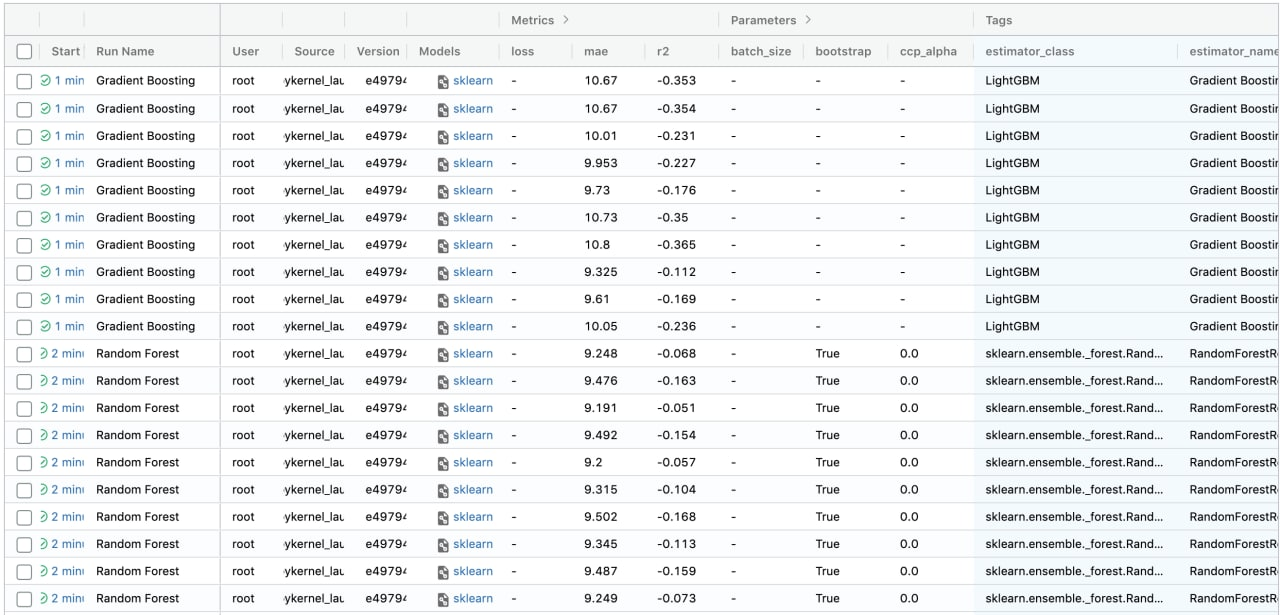
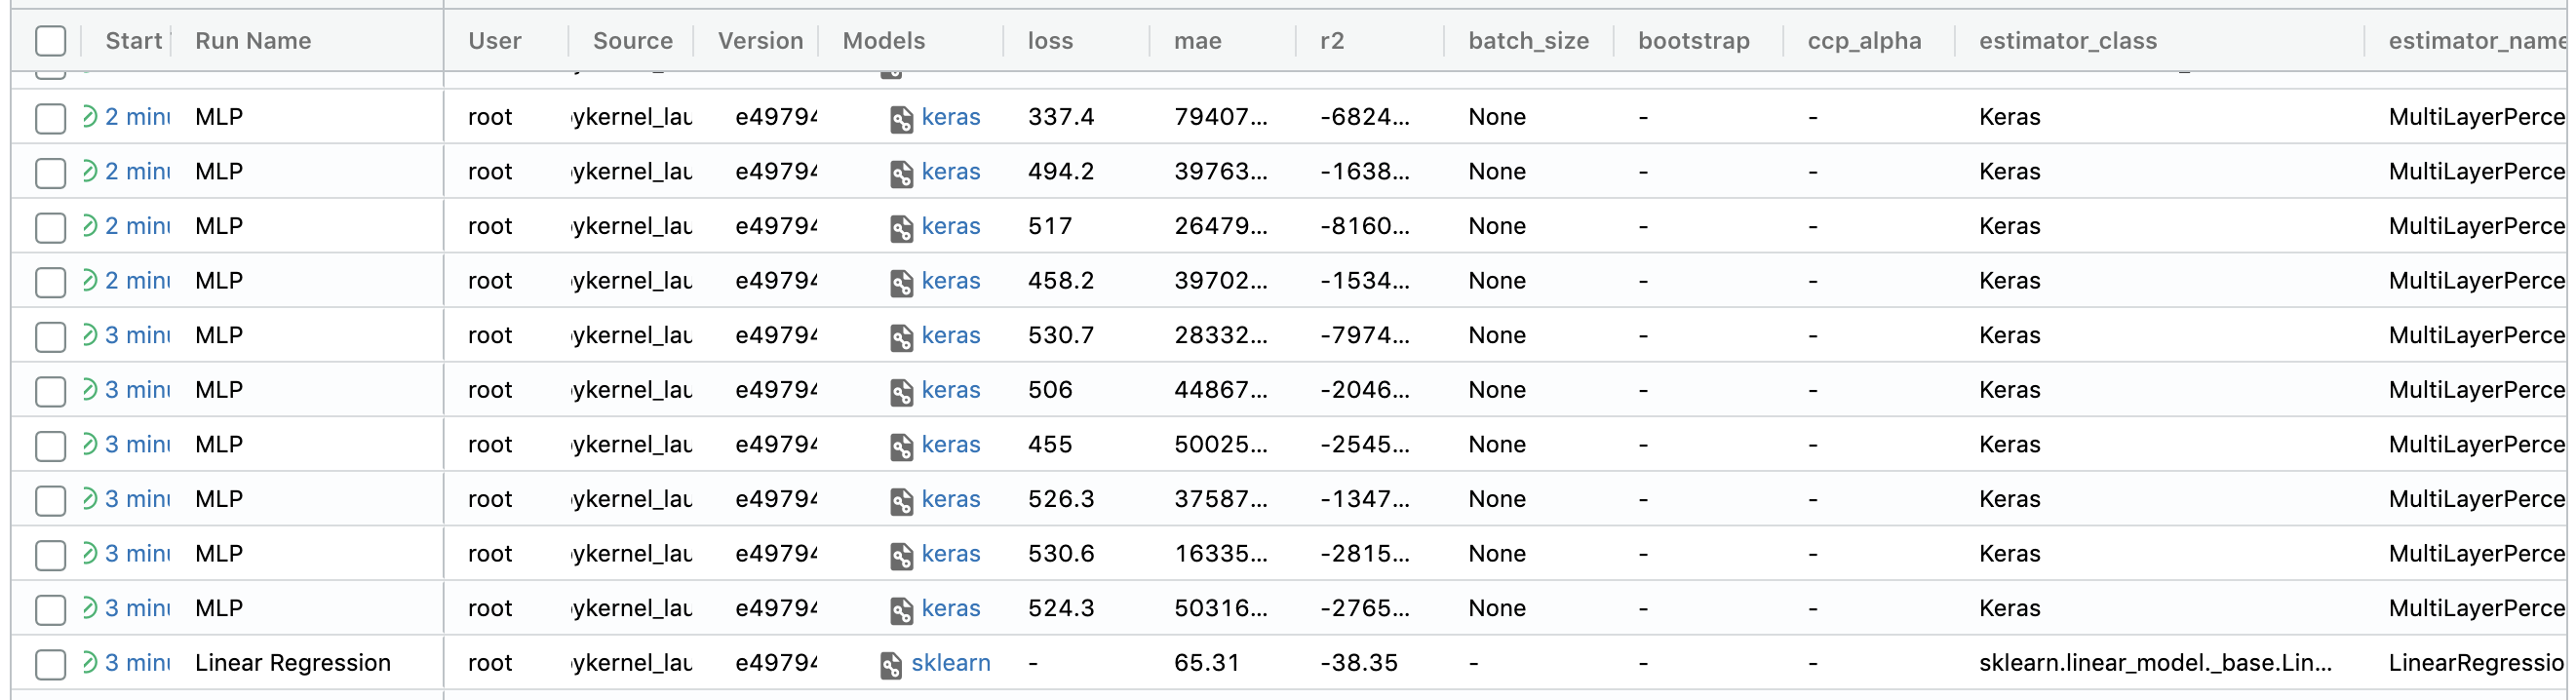

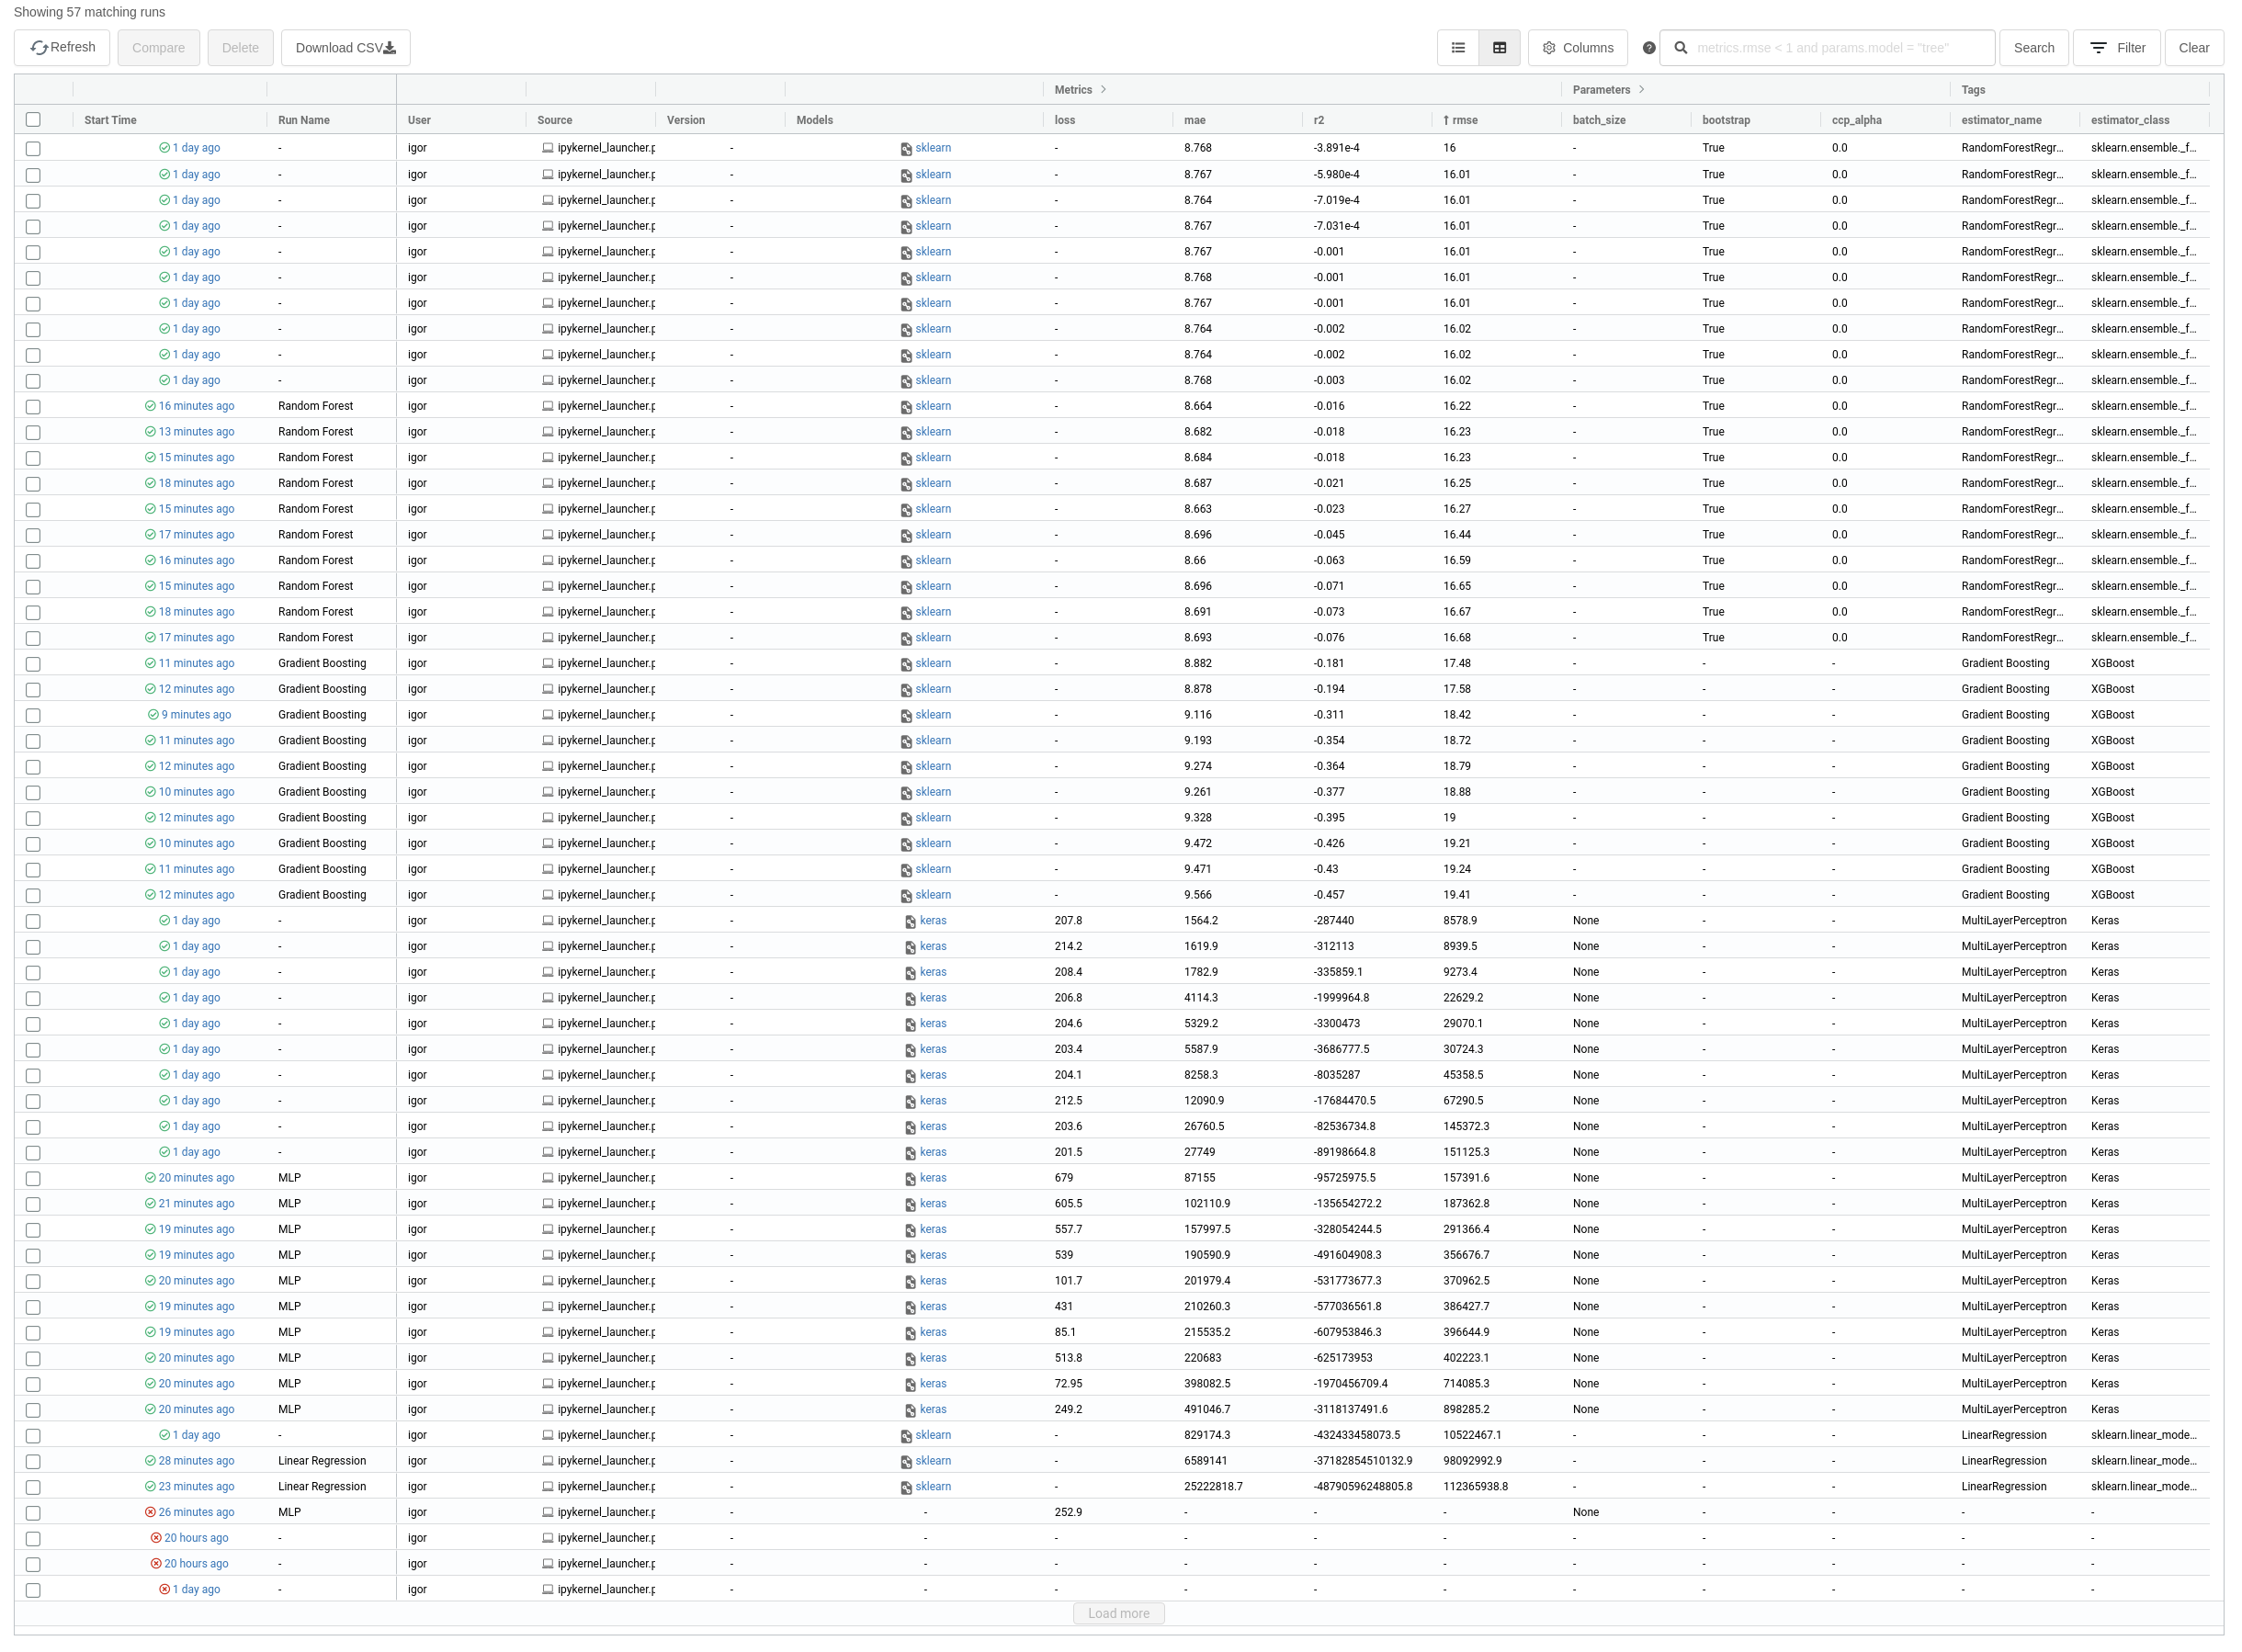

As we can see from the last image, both the linear regression and MLP models got the worst results, which is to be expected since we have a input with extremely high dimensionality, something that a simple linear regression isn't meant to handle, nor a MLP model that's both too shallow and without enough hidden units.

Both the RandomForest from Scikit-learn and the Gradient Boosting from XGBoost models got really similar results, with the RandomForest one being slightly better.

Since there's no reason to use those simpler models, we will just use our best tree models on our test data in order to further continue improving them.

### Running the test data on our best models.

Bellow we'll run the following models (the best runs) on our test data. Bellow you can find the parameters for the best RandomForest model:
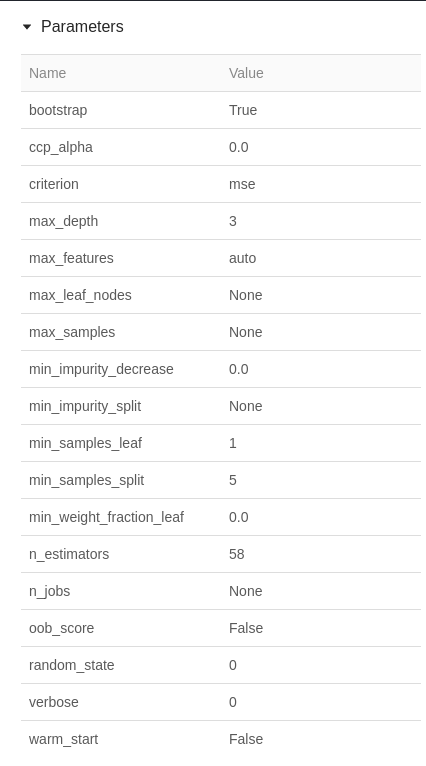

And the ones for the Gradient Boosting model:
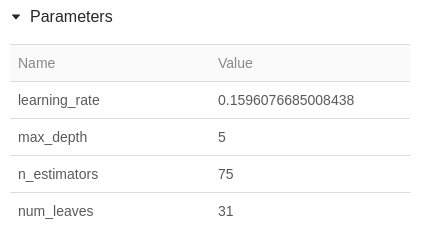

In [55]:
def gradient_boosting_test(params):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Gradient Boosting Best case"):

        model = XGBRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            learning_rate=params["learning_rate"],
        )
        model.fit(train, train_labels)
        
        predictions = model.predict(test)
        print('Prediction: %.3f' % predictions[0])
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("XGBoost model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.set_tags(
            {
                "estimator_class":"XGBoost",
                "estimator_name":"Gradient Boosting"
            }
        )
        mlflow.sklearn.log_model(model, "model")
        
        gc.collect()
        
        return rmse

In [56]:
params = {
    "max_depth": 5,
    "n_estimators": 75,
    "learning_rate": 0.1596076685008438
}
rmse_gradient_boosting = gradient_boosting_test(params)
print(rmse_gradient_boosting)

Prediction: 41.615
XGBoost model
  RMSE: 17.48348148939948
  MAE: 8.882227705497742
  R2: -0.18119769944298558
17.48348148939948


In [57]:
def random_forest_test(params):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Random Forest"):
        rf = RandomForestRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            min_samples_split=params["min_samples_split"],
            random_state=0
        )
        rf.fit(train, train_labels)
        
        predictions = rf.predict(test)
        
        (rmse, mae, r2) = eval_metrics(test_labels, predictions)
        
        print("Random Forest model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        
        gc.collect()
        
        return rmse

In [58]:
params = {
    "n_estimators": 58,
    "max_depth": 3,
    "min_samples_split":5,
}
rmse_random_forest = random_forest_test(params)

Random Forest model
  RMSE: 16.239853635289208
  MAE: 8.927073888502472
  R2: -0.032991543301319926


### Improving our best models
Now, since we have our baseline from the runs above onoo the test data, we'll try to improve those models a little further by tuning our hyperparameters a little bit.

In [59]:
params = {
    "max_depth": 5,
    "n_estimators": 70,
    "learning_rate": 0.1
}
rmse_gradient_boosting = gradient_boosting_test(params)
print(rmse_gradient_boosting)

Prediction: 39.341
XGBoost model
  RMSE: 17.140361658532274
  MAE: 8.80003314151764
  R2: -0.13528975502718898
17.140361658532274


In [64]:
params = {
    "n_estimators": 55,
    "max_depth": 3,
    "min_samples_split": 5,
}
rmse_random_forest = random_forest_test(params)

Random Forest model
  RMSE: 16.205734246561086
  MAE: 8.920035297658636
  R2: -0.028655541698723086


#### Gradient boosting improvments
On our best run of the gradient boosting we got the following results:
```
Prediction: 41.615
XGBoost model
  RMSE: 17.48348148939948
  MAE: 8.882227705497742
  R2: -0.18119769944298558
17.48348148939948
```
After manually tuning our parameters, we got the following results:
```
Prediction: 39.341
XGBoost model
  RMSE: 17.140361658532274
  MAE: 8.80003314151764
  R2: -0.13528975502718898
17.140361658532274
```

#### Random forest improvments
On our best run of the random forest we got the following results:
```
Random Forest model
  RMSE: 16.239853635289208
  MAE: 8.927073888502472
  R2: -0.032991543301319926
```
After manually tuning our parameters, we got the following results:
```
Random Forest model
  RMSE: 16.205734246561086
  MAE: 8.920035297658636
  R2: -0.028655541698723086
```

## Conclusion

Using MLFlow along with Optuna allowed us to get a general idea of where the best hyperparameters are headed, and then fine-tune those in order to improve our results even further, without needing to do an exhaustive grid search or try manually to find the optimal values.